In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSVs
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Resources/users.csv")
devices = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Resources/devices.csv")
traffic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Resources/network_traffic.csv")

# Merge user info into traffic
df = users.merge(traffic, on="user_id", how="right")

# Merge device info into traffic
df = devices.merge(df, on="device_id", how="right")

print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (10000, 17)


,device_id,device_type,os,user_id,username,department,role,log_id,timestamp,src_ip,dst_ip,protocol,port,bytes_sent,bytes_received,duration,is_anomaly
0,D0403,Laptop,Ubuntu 22.04,USR_EMP0028,e_tifcs28@company.com,HR,Recruiter,T00001,2022-02-19 08:39:32,192.168.215.198,10.0.241.5,SSH,22.0,6762.0,4230.0,23.31,1
1,D0282,Desktop,Ubuntu 20.04,USR_EMP0055,e_hodhj55@company.com,Marketing,SEO Specialist,T00002,2022-01-27 01:57:06,192.168.8.133,10.0.126.225,SMTP,25.0,2749.0,521.0,32.80,0
2,D0298,Desktop,Windows 10,USR_EMP0182,e_necba182@company.com,Finance,Accountant,T00003,2022-02-26 07:33:33,192.168.124.236,10.0.129.94,SSH,22.0,5479.0,4067.0,49.70,1
3,D0229,Laptop,Ubuntu 22.04,USR_EMP0031,e_sfphk31@company.com,Engineering,Data Scientist,T00004,2022-01-13 17:40:05,192.168.197.6,10.0.3.140,SSH,22.0,3397.0,2030.0,68.11,1
4,D0179,Desktop,Ubuntu 20.04,USR_EMP0193,e_ogtri193@company.com,Marketing,SEO Specialist,T00005,2022-01-26 17:49:33,192.168.241.180,10.0.237.144,SMTP,25.0,7370.0,5593.0,41.51,0


### Identifiers (should drop):

- log_id → just a row identifier, no predictive power.

- user_id, device_id, username → identifiers; if we leave them, the model may just memorize instead of generalizing.
(But note: user_id/device_id are already represented through their categorical attributes: department, role, device_type, os.)

### IPs (optional drop):

- src_ip, dst_ip → high-cardinality, nearly unique in your logs. Without network topology encoding, they’ll add noise. Better to drop for now.

### Retained Features:

- protocol, port, bytes_sent, bytes_receive, duration, department, role, device_type, os, and the engineered hour of day (we’ll create in next step).

### is_anomaly → target column.

In [4]:
# @title
# Drop columns
drop_cols = ["log_id", "user_id", "device_id", "username", "src_ip", "dst_ip"]

df = df.drop(columns=drop_cols)

print("Remaining columns:", df.columns.tolist())


Remaining columns: ['device_type', 'os', 'department', 'role', 'timestamp', 'protocol', 'port', 'bytes_sent', 'bytes_received', 'duration', 'is_anomaly']


In [5]:
# @title
# Since the hour of day might indicate the anomalous transaction, we'll retain only hour of the day from timestamp. Other parts (date, minute, second) don’t generalize well across datasets.

# Ensure timestamp is parsed correctly
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Extract hour of day (0–23)
df["hour"] = df["timestamp"].dt.hour

print(df[["timestamp", "hour"]].head())


            timestamp  hour
0 2022-02-19 08:39:32     8
1 2022-01-27 01:57:06     1
2 2022-02-26 07:33:33     7
3 2022-01-13 17:40:05    17
4 2022-01-26 17:49:33    17


In [6]:
# @title
# Feature Engineering Strategy for Numerical Features : scale them either minmax or standarization - start with StandardScaler.
# Strategy for Categorical Features : encode them with OHE or Embeddings - The existing categories are too less in quantity for embeddings to really work

# Identify feature groups
num_cols = ["bytes_sent", "bytes_received", "duration", "hour"]
cat_cols = ["protocol", "port", "department", "role", "device_type", "os"]

# Imputers

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_cols),
                  ("cat", categorical_transformer, cat_cols)])


X = df.drop(columns=["is_anomaly", "timestamp"])
y = df["is_anomaly"].astype(int).values


In [ ]:
# @title
# Info
# In Deep Learning, embeddings are a better way of extracting more meaningful info from them But the limited number of options in each categorical column makes pre-trained embeddings inefficient for the purpose
# Trainable embeddings can be a point of experimentation

In [7]:
# @title
# Split data

X = df.drop(columns=["is_anomaly", "timestamp"])
y = df["is_anomaly"].astype(int).values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [8]:
# @title
# Fitting Pre-Processor
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (7000, 47)
Val shape: (1500, 47)
Test shape: (1500, 47)


In [9]:
# @title
# Build and compile ANN model
model = Sequential([Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
                    Dropout(0.3),
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    Dense(1, activation="sigmoid")])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall")])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# @title
# Kick-in the training process
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7550 - auc: 0.5463 - loss: 0.5338 - precision: 0.1915 - recall: 0.0801 - val_accuracy: 0.8187 - val_auc: 0.7078 - val_loss: 0.4400 - val_precision: 1.0000 - val_recall: 0.0523
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8273 - auc: 0.7277 - loss: 0.4315 - precision: 0.7702 - recall: 0.1456 - val_accuracy: 0.8533 - val_auc: 0.7278 - val_loss: 0.4146 - val_precision: 0.8681 - val_recall: 0.2753
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8545 - auc: 0.7547 - loss: 0.4001 - precision: 0.8338 - recall: 0.2908 - val_accuracy: 0.8760 - val_auc: 0.7303 - val_loss: 0.3852 - val_precision: 0.9391 - val_recall: 0.3763
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8778 - auc: 0.7869 - loss: 0.3572 - precision: 0.8456 - recall: 0.4096 - val_accuracy: 0.8847 - val_auc: 0.7244 - val_loss: 0.3706 - val_precision: 0.9191 - val_recall: 0.4355
Epoch 5/10
110/110 ━━━━━━━━━━━━━

In [11]:
# @title
# Evaluate on test data
y_pred_prob = model.predict(X_test).ravel()     #or flatten() - just to convert shape (N,1) to (N,)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
 [[1199   14]
 [ 143  144]]

Classification Report:
               precision    recall  f1-score   support

           0      0.893     0.988     0.939      1213
           1      0.911     0.502     0.647       287

    accuracy                          0.895      1500
   macro avg      0.902     0.745     0.793      1500
weighted avg      0.897     0.895     0.883      1500

ROC-AUC: 0.7482556853598215


In [12]:
# @title
# Handling imbalance : Oversampling, class weights, undersampling (bad-idea, though!!)

# SMOTE Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
X_smote,y_smote = SMOTE(random_state=42).fit_resample(X_train,y_train)
X_under,y_under = RandomUnderSampler(random_state=42).fit_resample(X_smote,y_smote)

# Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)


Class Weights: {np.int64(0): np.float64(0.6184838310655593), np.int64(1): np.float64(2.609992542878449)}


In [ ]:
# Principle of Autoencoders - Runs a encoder-decoder architecture aimed at reconstructing data.
# We train the autoencoders on normal data.
# Incase of anomalous data the encoder-decoder architecture fails to reconstruct the data.

In [13]:
X.shape, y.shape

((10000, 10), (10000,))

In [ ]:
# We'll split nonanomalous data into training and validation. A portion of it can be kept for testing as well.
# But non-anomalous data is put only in testing, as that's when it can detect anomaly.

In [14]:
# Split NORMAL samples

X_norm = X[y == 0]
y_norm = y[y == 0]

# 75% train, 15% val, 10% test
X_train_norm, X_temp_norm, y_train_norm, y_temp_norm = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)  # leaves 75% train, 25% temp
X_val_norm, X_test_norm, y_val_norm, y_test_norm = train_test_split(X_temp_norm, y_temp_norm, test_size=0.4, random_state=42)  # 15% val, 10% test

print("Train normals:", X_train_norm.shape)
print("Val normals:", X_val_norm.shape)
print("Test normals:", X_test_norm.shape)

Train normals: (6063, 10)
Val normals: (1213, 10)
Test normals: (809, 10)


In [15]:
# Collect ANOMALOUS samples (all for test)

X_anom = X[y == 1]
y_anom = y[y == 1]

print("Anomalies:", X_anom.shape)

Anomalies: (1915, 10)


In [16]:
# Final test set = 10% normals + all anomalies

X_test = pd.concat([X_test_norm, X_anom], axis=0)
y_test = np.concatenate([y_test_norm, y_anom])

print("Final Test set:", X_test.shape, "with anomalies:", (y_test == 1).sum())

Final Test set: (2724, 10) with anomalies: 1915


In [17]:
# We'll use same preprocessor

X_train_prep = preprocessor.fit_transform(X_train_norm)
X_val_prep   = preprocessor.transform(X_val_norm)
X_test_prep  = preprocessor.transform(X_test)

# Convert csr matrix into np array format. Else can use sparse_output=False as an option in pipeline

X_train_prep = X_train_prep.toarray().astype("float32")
X_val_prep   = X_val_prep.toarray().astype("float32")
X_test_prep  = X_test_prep.toarray().astype("float32")

In [18]:
# Build Autoencoder

input_dim = X_train_prep.shape[1]

autoencoder = Sequential()

# Encoder
autoencoder.add(Dense(128, activation="relu", input_shape=(input_dim,)))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(64, activation="relu"))
autoencoder.add(Dense(32, activation="relu"))
autoencoder.add(Dense(16, activation="relu"))   # bottleneck

# Decoder
autoencoder.add(Dense(32, activation="relu"))
autoencoder.add(Dense(64, activation="relu"))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(128, activation="relu"))
autoencoder.add(Dense(input_dim))  # reconstruct input

# Define r2 score, because its our common metric for regression

import tensorflow as tf
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())

# Compile
autoencoder.compile(optimizer="adam", loss="mse", metrics= [r2_score])
autoencoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,047 (133.00 KB)

 Trainable params: 34,047 (133.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train Autoencoder

history = autoencoder.fit(
    X_train_prep, X_train_prep,
    validation_data=(X_val_prep, X_val_prep),
    epochs=50,
    batch_size=64,
    verbose=1)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1900 - r2_score: 0.0305 - val_loss: 0.1177 - val_r2_score: 0.4032
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1198 - r2_score: 0.3893 - val_loss: 0.0982 - val_r2_score: 0.5020
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1036 - r2_score: 0.4713 - val_loss: 0.0865 - val_r2_score: 0.5614
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0945 - r2_score: 0.5192 - val_loss: 0.0750 - val_r2_score: 0.6194
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0843 - r2_score: 0.5724 - val_loss: 0.0681 - val_r2_score: 0.6546
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0791 - r2_score: 0.5973 - val_loss: 0.0640 - val_r2_score: 0.6752
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0749 - r2_score: 0.6201 - val_loss: 0.0595 - val_r2_score: 0.6984
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0723 - r2_score: 0.6334 - val_loss: 0.0573 - val_r2_score

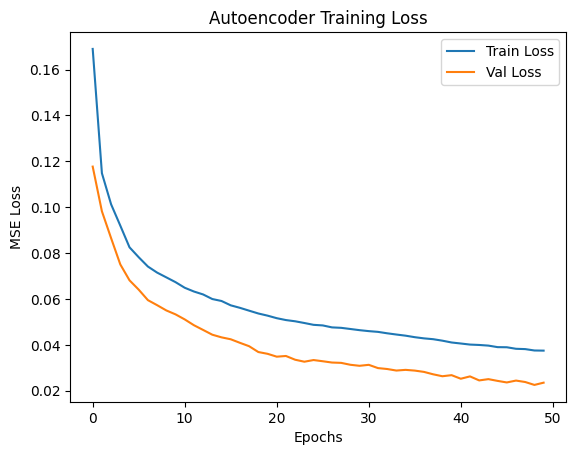

In [20]:
# Loss over Epochs
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend(); plt.show()


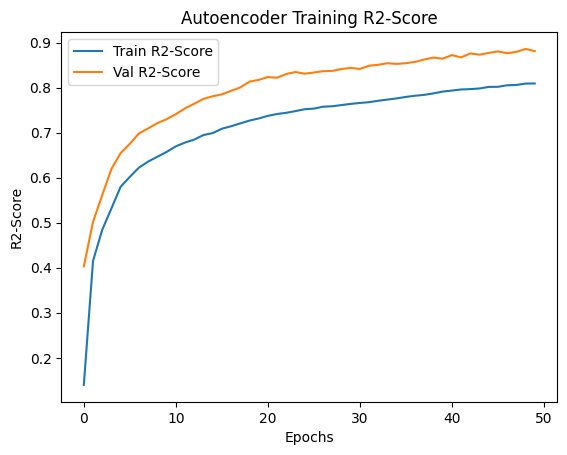

In [21]:
# R2 score over Epochs
import matplotlib.pyplot as plt

plt.plot(history.history["r2_score"], label="Train R2-Score")
plt.plot(history.history["val_r2_score"], label="Val R2-Score")
plt.xlabel("Epochs"); plt.ylabel("R2-Score")
plt.title("Autoencoder Training R2-Score")
plt.legend(); plt.show()

In [22]:
# Reconstruction Error - Testing and Evaluation

X_test_pred = autoencoder.predict(X_test_prep)
mse = np.mean(np.power(X_test_prep - X_test_pred, 2), axis=1)  # Manually calculating mse since keras mse gives batchwise mse.

# Threshold = 95th percentile of train normals' reconstruction error
X_train_pred = autoencoder.predict(X_train_prep)
mse_train = np.mean(np.power(X_train_prep - X_train_pred, 2), axis=1)
threshold = np.percentile(mse_train, 95)
print("Threshold (95th percentile of normal errors):", threshold)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold (95th percentile of normal errors): 0.04173778


In [23]:
# Predictions - Our criterion for right/wrong is just error being more than max of normal error. That decides whether that point is anomalous or not.

threshold = 0.025  #np.percentile(mse_train, 95)
y_pred = (mse > threshold).astype(int)  #Gives 0 or 1 based on error passing threshold

In [24]:
# =Evaluation

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC-AUC (using reconstruction error):", roc_auc_score(y_test, mse))



Confusion Matrix:
 [[ 474  335]
 [ 718 1197]]

Classification Report:
               precision    recall  f1-score   support

           0      0.398     0.586     0.474       809
           1      0.781     0.625     0.695      1915

    accuracy                          0.613      2724
   macro avg      0.589     0.605     0.584      2724
weighted avg      0.667     0.613     0.629      2724

ROC-AUC (using reconstruction error): 0.6824755443815818


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


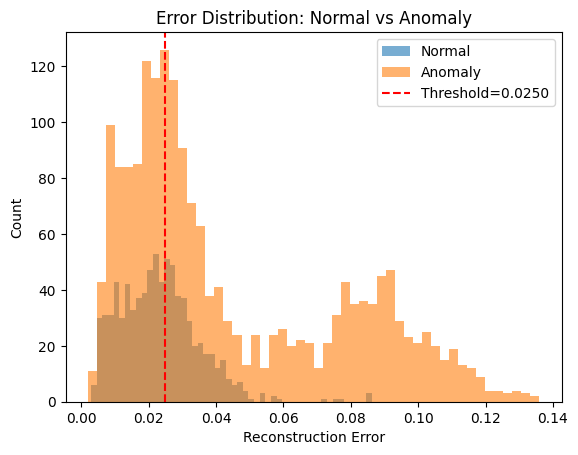

In [25]:
# Distribution of reconstruction errors
# Reconstruction errors on test set
X_test_pred = autoencoder.predict(X_test_prep)
mse_test = np.mean(np.power(X_test_prep - X_test_pred, 2), axis=1)

plt.hist(mse_test[y_test==0], bins=50, alpha=0.6, label="Normal")
plt.hist(mse_test[y_test==1], bins=50, alpha=0.6, label="Anomaly")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold={threshold:.4f}")
plt.xlabel("Reconstruction Error"); plt.ylabel("Count")
plt.title("Error Distribution: Normal vs Anomaly")
plt.legend(); plt.show()


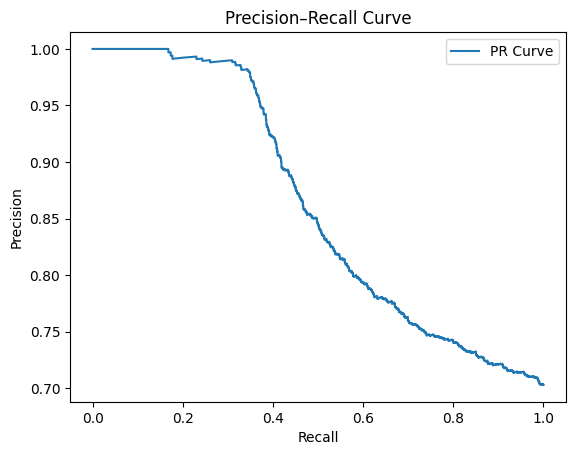

In [26]:
# Precision-Recall tradeoff

from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, mse_test)

plt.plot(rec, prec, label="PR Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(); plt.show()

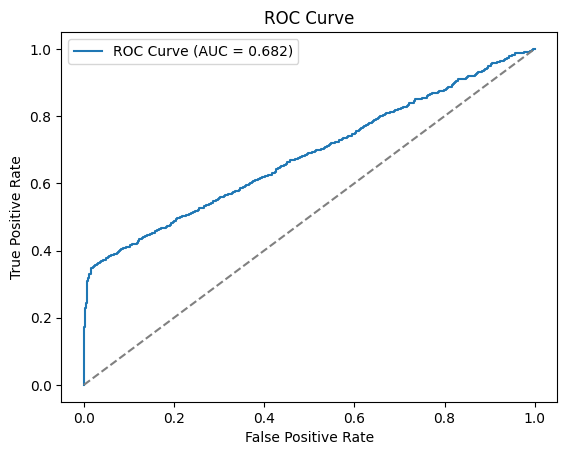

In [27]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, mse_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()
